In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

# Ładowanie i podział zbioru danych

In [2]:
data = pd.read_csv("./data/bank-full.csv")
data.shape

(45211, 17)

In [3]:
build, val = train_test_split(data, test_size=0.3,random_state=42)
train, test = train_test_split(build, test_size=0.3, random_state=42)

In [4]:
df = train.iloc[:, 8:16].copy()
df.shape

(22152, 8)

# Eksploracyjna analiza danych

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22152 entries, 28440 to 36613
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   contact   22152 non-null  object
 1   day       22152 non-null  int64 
 2   month     22152 non-null  object
 3   duration  22152 non-null  int64 
 4   campaign  22152 non-null  int64 
 5   pdays     22152 non-null  int64 
 6   previous  22152 non-null  int64 
 7   poutcome  22152 non-null  object
dtypes: int64(5), object(3)
memory usage: 1.5+ MB


Brak braków danych, kolumny zarówno numeryczne jak i kategoryczne

In [6]:
df.describe()

,day,duration,campaign,pdays,previous
count,22152.000000,22152.000000,22152.000000,22152.000000,22152.000000
mean,15.863714,257.111547,2.767606,40.539410,0.586087
std,8.311830,256.093527,3.123506,101.040739,2.600391
min,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,21.000000,318.000000,3.000000,-1.000000,0.000000
max,31.000000,4918.000000,58.000000,871.000000,275.000000


## Contact

Rodzaj komunikacji z klientem

In [7]:
df.contact.value_counts()

cellular     14413
unknown       6334
telephone     1405
Name: contact, dtype: int64

## Day

Dzień miesiąca, w którym nastąpił ostatni kontakt z klientem

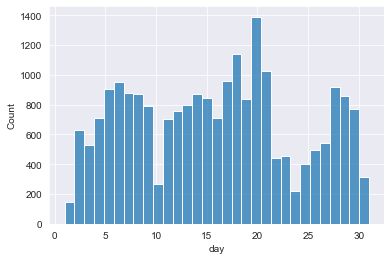

In [8]:
sns.histplot(df.day, bins=31)
plt.show()

Obserwujemy zmniejszoną aktywność 1., 10. i 24. dnia każdego miesiąca i intrygujący peak 20. dnia miesiąca.

## Month

Miesiąc, w którym nastąpił ostatni kontakt z klientem

In [9]:
df.month.value_counts()

may    6678
jul    3382
aug    3018
jun    2635
nov    1961
apr    1457
feb    1324
jan     695
oct     370
sep     284
mar     236
dec     112
Name: month, dtype: int64

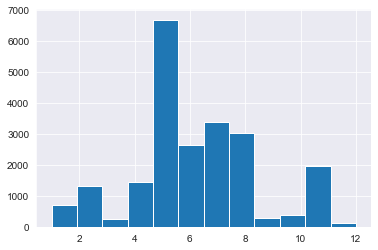

In [10]:
df.replace({"month":{"jan":1,"feb":2,"mar":3,"apr":4,"may":5,"jun":6,"jul":7,"aug":8,"sep":9,"oct":10,"nov":11,"dec":12}}).month.hist(bins=12)
plt.show()

Widzimy nasilenie w miesiącach wiosennych i letnich - duży peak w maju, rzadziej jesienią i zimą (z wyjątkiem października)

## Duration

Czas w sekundach ostatniego kontaktu z klientem

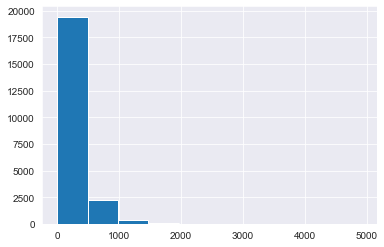

In [11]:
df.duration.hist()
plt.show()

Być może są obecne wartości odstające

In [12]:
df.duration.sort_values(ascending=False)

24148    4918
9947     3881
44602    3785
30747    3102
6451     3094
         ... 
2599        3
287         2
31740       1
22937       0
36425       0
Name: duration, Length: 22152, dtype: int64

Potraktujemy czas trwania połączenia powyżej 2000 sekund jako outlier, żeby nie psuło nam to za bardzo scalingu

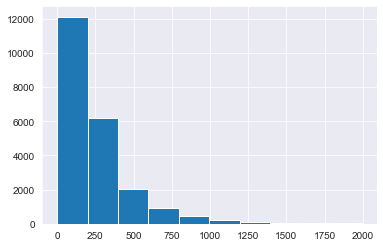

In [13]:
df[df.duration<2000].duration.hist()
plt.show()

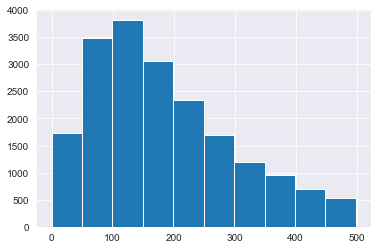

In [14]:
df[df.duration<500].duration.hist()
plt.show()

## Campaign

Liczba kontaktów z klientem w aktualnej kampanii (włączając ostatni kontakt)

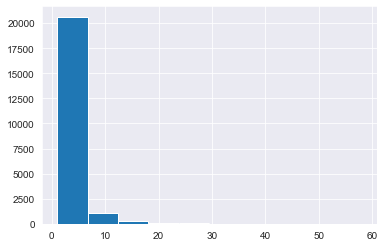

In [15]:
df.campaign.hist()
plt.show()

In [16]:
df.campaign.sort_values(ascending=False)

11914    58
18713    50
10697    46
18744    44
18660    43
         ..
41076     1
7604      1
27081     1
4386      1
36613     1
Name: campaign, Length: 22152, dtype: int64

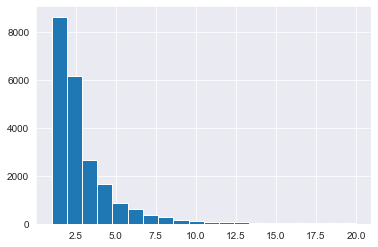

In [17]:
df[df.campaign<=20].campaign.hist(bins=20)
plt.show()

## Pdays

Liczba dni, które upłynęły od ostatniego kontaktu z klientem z poprzedniej kampanii (-1 oznacza brak kontaktu w poprzedniej kampanii)

In [18]:
df[df.pdays == -1].size/df.size

0.8158631274828458

Dla większośći klientów jest to pierwsza kampania, w której uczestniczą

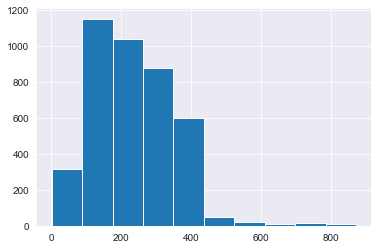

In [19]:
df[df.pdays != -1].pdays.hist()
plt.show()

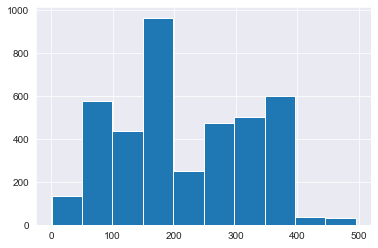

In [20]:
df[(df.pdays != -1) & (df.pdays < 500)].pdays.hist()
plt.show()

## Previous

Liczba kontaktów z klientem przed aktualną kampanią

In [21]:
df[df.previous == 0].size/df.size

0.8158631274828458

Analogicznie

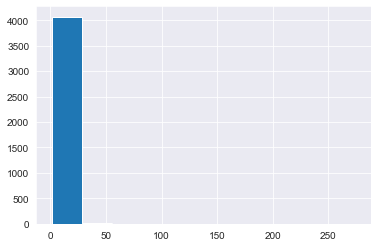

In [22]:
df[df.previous != 0].previous.hist()
plt.show()

Występują pewne outliery

In [23]:
df.previous.sort_values(ascending=False)

29182    275
44822     41
42611     40
37567     38
42422     37
        ... 
42237      0
6928       0
12723      0
23308      0
36613      0
Name: previous, Length: 22152, dtype: int64

No te 275 dość sporo

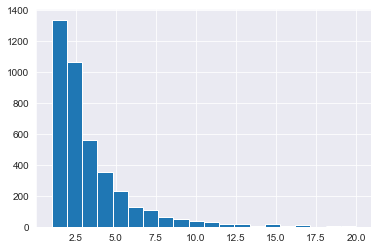

In [24]:
df[(df.previous != 0) & (df.previous <= 20)].previous.hist(bins=20)
plt.show()

## Poutcome

Rezultat poprzedniej kampanii

In [25]:
df.poutcome.value_counts()

unknown    18076
failure     2404
other        924
success      748
Name: poutcome, dtype: int64

In [26]:
df[df.poutcome == 'unknown'].size - df[df.previous == 0].size

24

Sporo nieznanych wartości, ale tylko w 24 przypadkach z innego powodu niż pierwszego udziału klienta w kampani. Spróbujemy z kodowaniem one hot encoding ale być może usuniemy tą zmienną

## Korelacja

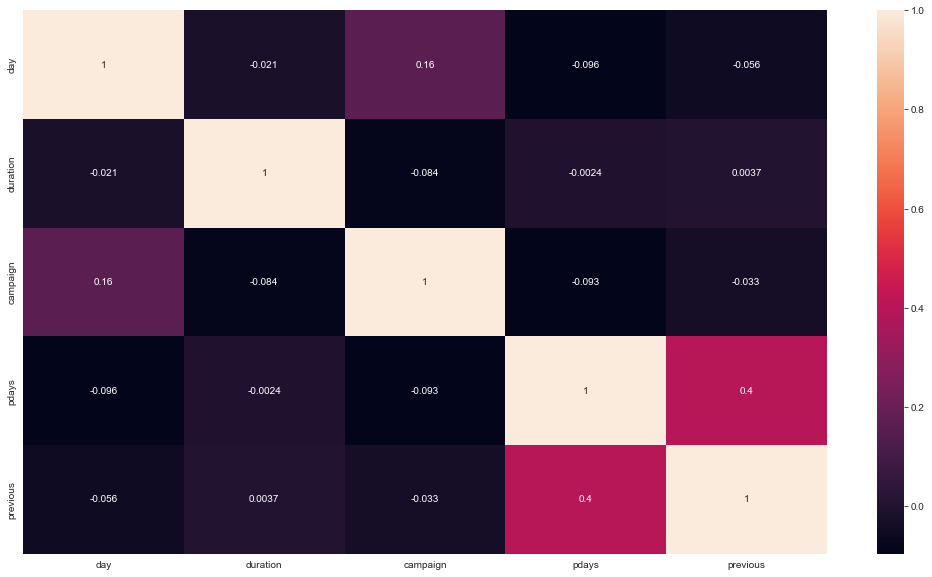

In [27]:
plt.figure(figsize=(18,10))
sns.heatmap(df.corr(method='pearson'),annot=True)
plt.show()

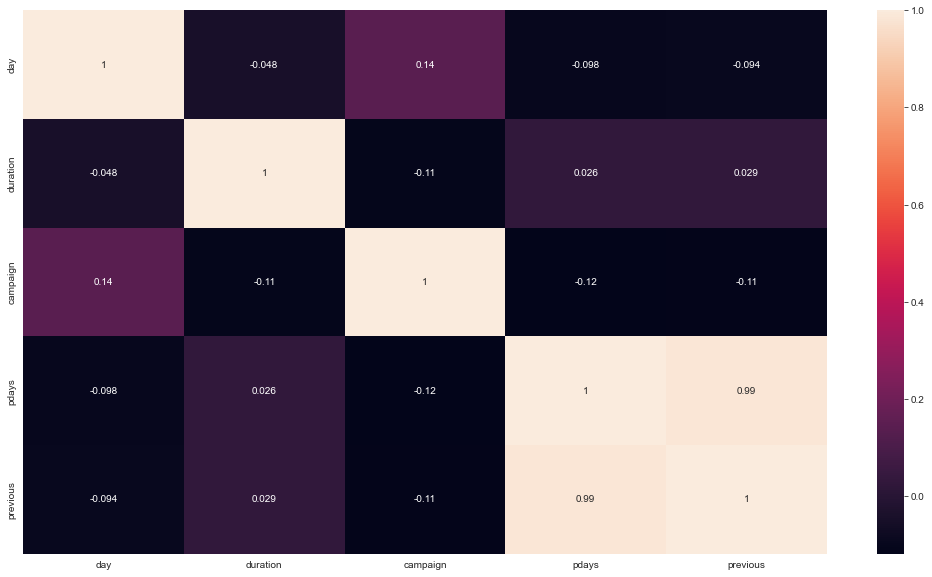

In [28]:
plt.figure(figsize=(18,10))
sns.heatmap(df.corr(method='spearman'),annot=True)
plt.show()

Oczywista korelacja pomiędzy liczbą dni od ostatniego kontaktu z poprzedniej kampanii a liczbą kontaktów z poprzedniej kampanii. Zobaczmy jeszcze korelację zmiennych numerycznych z kategorycznymi

In [29]:
col_transformer = ColumnTransformer(
    transformers=[
        ('passthrough','passthrough', ['duration', 'campaign', 'pdays', 'previous', 'day']),
        ('cat', OneHotEncoder(sparse_output=False), ['contact', 'poutcome']),
    ])
encoding_pipeline = Pipeline([
    ('col_transformer', col_transformer)]).fit(df)

colnames = pd.Index(['duration', 'campaign', 'pdays', 'previous', 'IsFirstCampaign']).append(pd.Index(col_transformer.named_transformers_['cat'].get_feature_names_out(['contact', 'poutcome'])))

encoded_df = pd.DataFrame(encoding_pipeline.transform(df), columns=colnames)

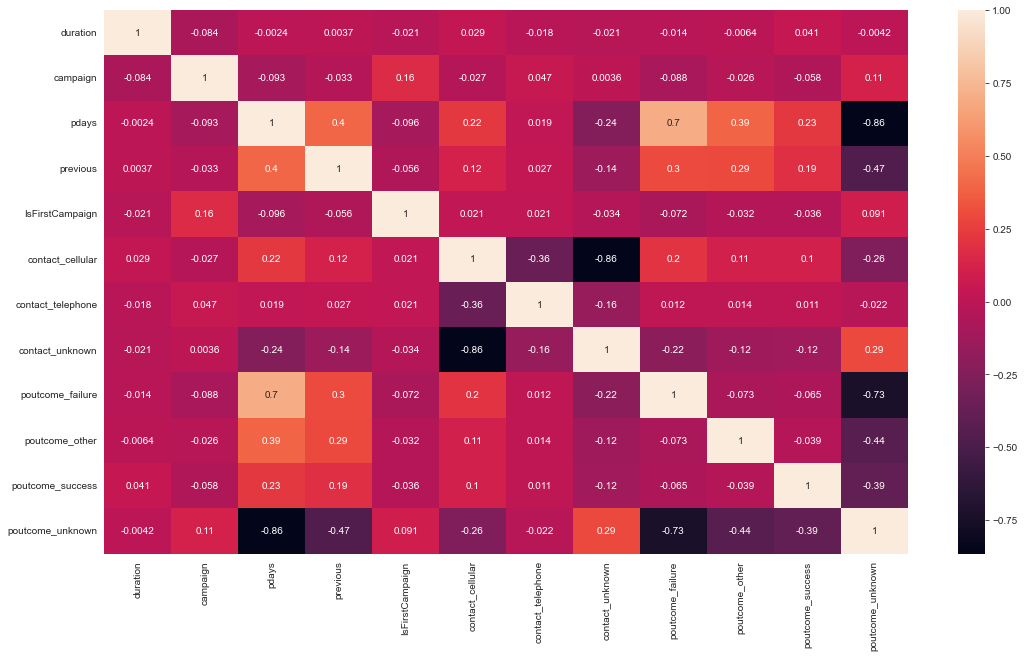

In [30]:
plt.figure(figsize=(18,10))
sns.heatmap(encoded_df.corr(method='pearson'),annot=True)
plt.show()

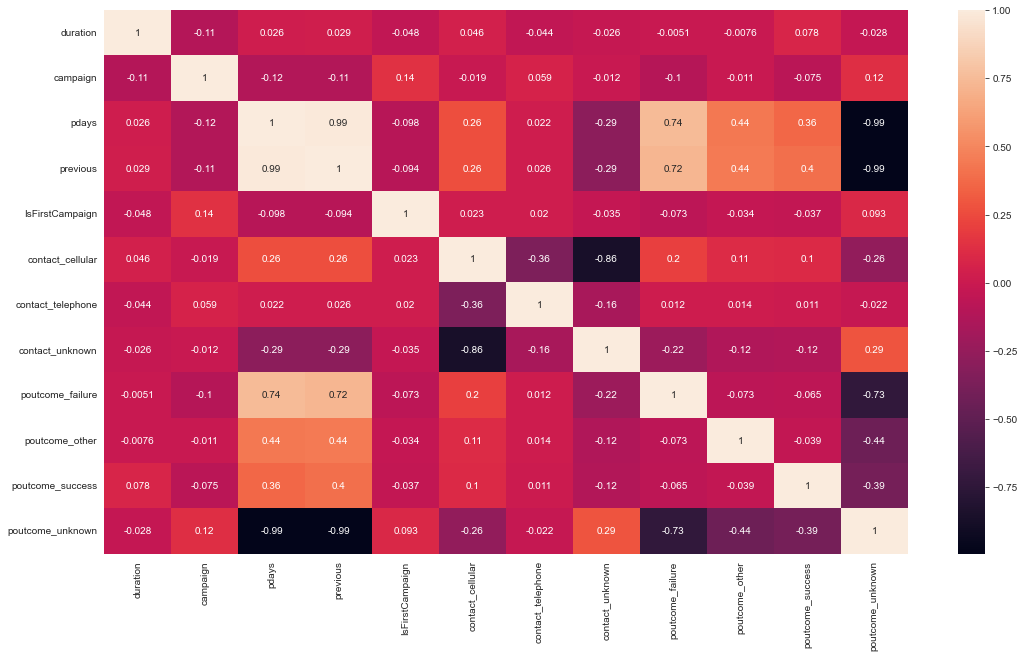

In [31]:
plt.figure(figsize=(18,10))
sns.heatmap(encoded_df.corr(method='spearman'),annot=True)
plt.show()

# Preprocessing

### Przetworzenie outlierów

Zamieniamy na medianę wartości, które na podstawie histogramów traktujemy jako otuliery

In [32]:
class OutlierTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.duration_median = None
        self.campaign_median = None
        self.previous_median = None

    def fit(self, df):
        self.duration_median = np.median(df["duration"])
        self.campaign_median = np.median(df["campaign"])
        self.previous_median = np.median(df["previous"])
        return self

    def transform(self, df):
        df.loc[df["duration"] > 2000, "duration"] = self.duration_median
        df.loc[df["campaign"] > 20, "campaign"] = self.campaign_median
        df.loc[df["previous"] > 20, "previous"] = self.previous_median
        return df

### Nowe zmienne

Tworzymy zmienną binarną IsFirstCampaign opisującą, czy aktualna kampania jest pierwszą dla klienta.

In [33]:
def add_features(df):
    df["IsFirstCampaign"] = np.where(df.previous == 0, 1, 0)
    return df

### Kodowanie zmiennych kategorycznych, standaryzacja i selekcja zmiennych

- Kodujemy zmienne contact, month, poutcome za pomocą one hot encodingu
- Standaryzujemy zmienne duration, campaign, pdays i previous
- Usuwamy zmienną day

###### :0

# PART II

## Zapoznanie z danymi

In [34]:
data = pd.read_csv("./data/bank-full.csv")
data.shape

(45211, 17)

In [35]:
df = data.iloc[:,0:8]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
dtypes: int64(2), object(6)
memory usage: 2.8+ MB


In [4]:
df.head(5)

,age,job,marital,education,default,balance,housing,loan
0,58,management,married,tertiary,no,2143,yes,no
1,44,technician,single,secondary,no,29,yes,no
2,33,entrepreneur,married,secondary,no,2,yes,yes
3,47,blue-collar,married,unknown,no,1506,yes,no
4,33,unknown,single,unknown,no,1,no,no


Brak nulli, 2 cechy liczbowe i 6 kategorycznych

### Age

In [5]:
df['age'].describe()

count    45211.000000
mean        40.936210
std         10.618762
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

Jak widzimy, wartości są prawdopodobne - min = 18 i max = 95. Z tego powodu nie przewiduje żadnych outlierów.

Jednak, jako że wiek liczbowo może nie być odpowiedni, postanowiliśym zakodować wiek zależnie od różnych grup wiekowych:

In [6]:
def age_group(age):
    if 18 <= age <= 25:
        return '18-25'
    if 25 < age <= 40:
        return '25-40'
    if 40 < age <= 55:
        return '40-55' 
    if 55 < age <= 70:
        return '55-70' 
    return '70+'

In [7]:
df['age'] = data['age'].apply(lambda x: age_group(x))

In [8]:
df['age'].value_counts()

age
25-40    23381
40-55    15594
55-70     4413
18-25     1336
70+        487
Name: count, dtype: int64

In [32]:
def age_coder(df):
    df['age'] = data['age'].apply(lambda x: age_group(x))
    return df

Zakodowaliśmy 

### Balance

In [9]:
df['balance'].describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

<Axes: xlabel='balance', ylabel='Count'>

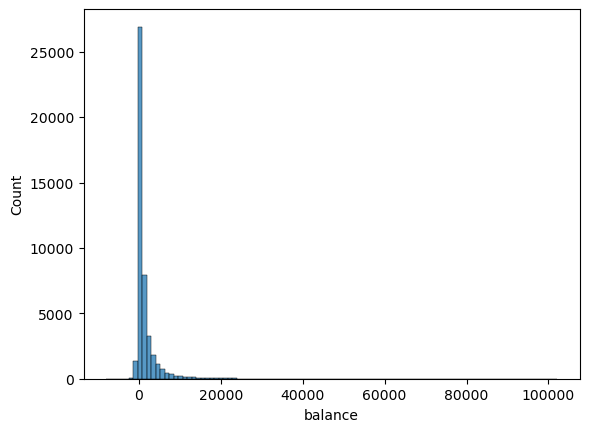

In [10]:
sns.histplot(df.balance, bins=100)

Widzimy bardzo lewoskośny zbiór. Z tego powodu użyjemy skalowania yeo-johnson:

In [11]:
df['balance'] = data['balance'].apply(lambda x: np.log(x + 1))

In [22]:
pt = PowerTransformer(method = 'yeo-johnson')
df.balance = pt.fit_transform(np.asarray(df['balance']).reshape(-1,1))

In [29]:
scaler = MinMaxScaler()
df.balance = scaler.fit_transform(np.asarray(df.balance).reshape(-1,1))

<Axes: xlabel='balance', ylabel='Count'>

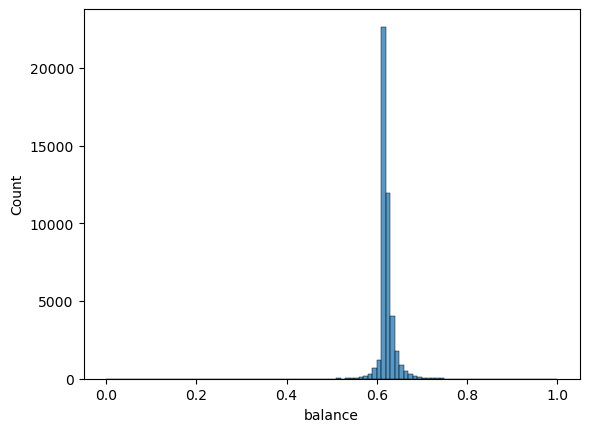

In [32]:
sns.histplot(df.balance, bins=100)

In [33]:
df.balance.describe()

count    45211.000000
mean         0.622665
std          0.017852
min          0.000000
25%          0.615802
50%          0.619003
75%          0.625703
max          1.000000
Name: balance, dtype: float64

Jak widzimy, sytuacja znacznie się poprawiła.

### Default, Housing, loan

Te 3 cechy są prostymi binarnymi o wartościach yes i no.

In [13]:
bin_enc = LabelEncoder()

In [14]:
bin_enc.fit(df.default)

LabelEncoder()

In [15]:
df.default = bin_enc.transform(df.default)

In [16]:
df.loan = bin_enc.transform(df.loan)

In [17]:
df.housing = bin_enc.transform(df.housing)

In [40]:
def Code_binary(df):
    bin_enc = LabelEncoder()
    bin_enc.fit(df.default)
    df.default = bin_enc.transform(df.default)
    df.loan = bin_enc.transform(df.loan)
    df.housing = bin_enc.transform(df.housing)
    return df

### Job, Education, Marital

In [18]:
df.job.value_counts()

job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64

In [19]:
encoder = OneHotEncoder()
encoder.fit(df[['job', 'age', 'education','marital']])

OneHotEncoder()

In [20]:
df_coded = pd.DataFrame(encoder.transform(df[['job', 'age', 'education','marital']]).toarray())

In [21]:
encoder.categories_

[array(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
        'retired', 'self-employed', 'services', 'student', 'technician',
        'unemployed', 'unknown'], dtype=object),
 array(['18-25', '25-40', '40-55', '55-70', '70+'], dtype=object),
 array(['primary', 'secondary', 'tertiary', 'unknown'], dtype=object),
 array(['divorced', 'married', 'single'], dtype=object)]

In [22]:
df_coded.columns = encoder.get_feature_names_out()

In [23]:
df_coded

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,age_40-55,age_55-70,age_70+,education_primary,education_secondary,education_tertiary,education_unknown,marital_divorced,marital_married,marital_single
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45207,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
45208,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45209,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [37]:
def encode_cat(df):
    encoder = OneHotEncoder()
    encoder.fit(df[['job', 'age', 'education','marital']])
    df_coded = pd.DataFrame(encoder.transform(df[['job', 'age', 'education','marital']]).toarray())
    df_coded.columns = encoder.get_feature_names_out()
    return df_coded

### Łączenie

In [30]:
df_pp = df_coded.join([df.default, df.housing, df.balance, df.loan])
df_pp

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,education_secondary,education_tertiary,education_unknown,marital_divorced,marital_married,marital_single,default,housing,balance,loan
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0,1,7.670429,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0,1,3.401197,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0,1,1.098612,1
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0,1,7.317876,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0,0,0.693147,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0,0,6.716595,0
45207,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0,0,7.455877,0
45208,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0,0,8.651025,0
45209,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0,0,6.505784,0


## Korelacja

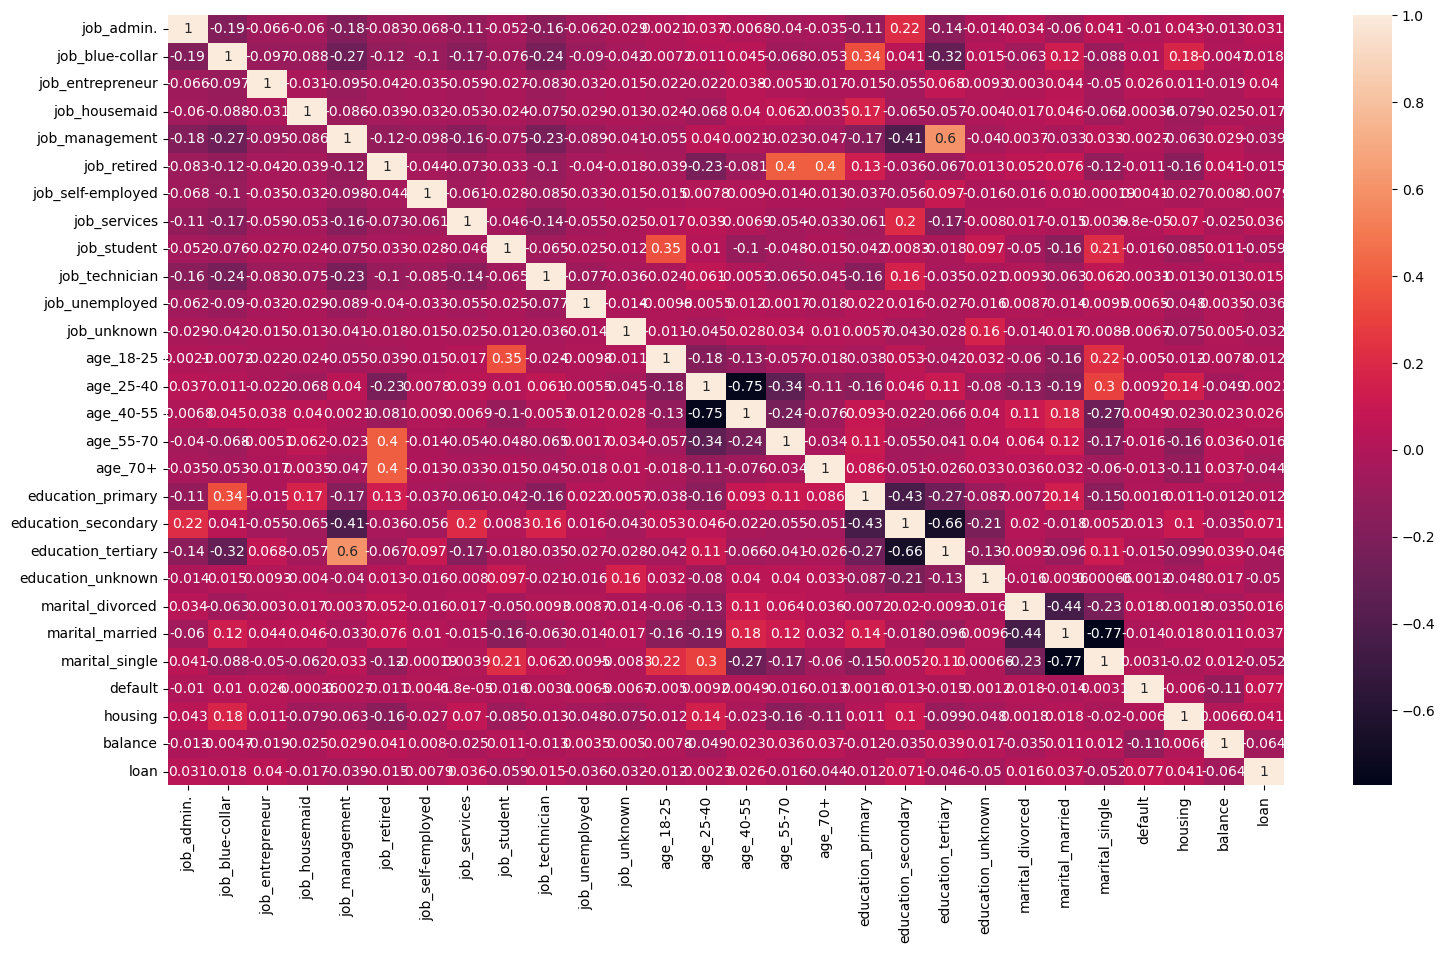

In [26]:
plt.figure(figsize=(18,10))
sns.heatmap(df_pp.corr(method='pearson'),annot=True)
plt.show()